## Lesson preamble

### Lecture objectives

- Understand which types of figures are suitable to create from raw data.
- Learn how to avoid common pitfalls when plotting large data sets.
- Learn about tidy data.
- Transform data from the long to wide format.

### Lecture outline

- Visualization tips and tricks
    - Choose informative plots for categorical data (35 min)
    - Making plots accessible through suitable color choices (10 min)
    - Avoiding saturated plots (40 min)
- Reshaping with data with `pivot()`, `pivot_table()`, and `melt()` (40 min)

# Visualization tips and tricks

In [1]:
# Setup by loading the data set from the previous lecture
import pandas as pd

world_data = pd.read_csv('../data/world-data-gapminder.csv')
# If you don't have the dataset locally 
# world_data = pd.read_csv('https://raw.githubusercontent.com/UofTCoders/2018-09-10-utoronto/gh-pages/data/world-data-gapminder.csv')

world_data.head()

,country,year,population,region,sub_region,income_group,life_expectancy,income,children_per_woman,child_mortality,pop_density,co2_per_capita,years_in_school_men,years_in_school_women
0,Afghanistan,1800,3280000,Asia,Southern Asia,Low,28.2,603,7.0,469.0,NaN,NaN,NaN,NaN
1,Afghanistan,1801,3280000,Asia,Southern Asia,Low,28.2,603,7.0,469.0,NaN,NaN,NaN,NaN
2,Afghanistan,1802,3280000,Asia,Southern Asia,Low,28.2,603,7.0,469.0,NaN,NaN,NaN,NaN
3,Afghanistan,1803,3280000,Asia,Southern Asia,Low,28.2,603,7.0,469.0,NaN,NaN,NaN,NaN
4,Afghanistan,1804,3280000,Asia,Southern Asia,Low,28.2,603,7.0,469.0,NaN,NaN,NaN,NaN


## Choosing informative plots for categorical data

When visualizing data it is important to explore different plotting options and reflect on which one best conveys the information within the data. In the following code cells, a sample data set is loaded from the `seaborn` data library in order to illustrate some advantages and disadvantages between categorical plot types. This is the same data as was used in lecture 1 and contains three different species of iris flowers and measurements of their sepals and petals.

First let's set the `seaborn` style to something different than last lecture, and to subset the data to only include observations from 2018.

In [2]:
import seaborn as sns

sns.set(context='notebook', style='darkgrid', palette='muted', font_scale=1.3)

world_data_2018 = world_data.loc[world_data['year'] == 2018]

### Bar plots

A common visualization when comparing a groups is to create a barplot of the means of each group and plot them next to each other.

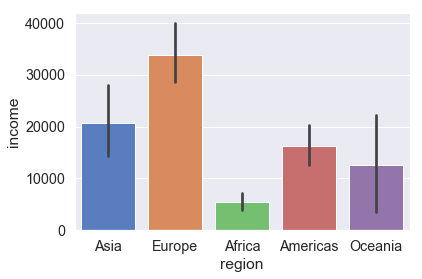

In [3]:
sns.barplot(x='region', y='income', data=world_data_2018)

This barplot shows the mean and the 95% confidence interval. Since the `seaborn` plotting functions returns a `matplotlib` axes object, these can be used with any `matplotlib` functions. Let's use this to our advantage to create a visualization comparison between four types of distribution or estimate plots. By creating a figure using `subplots()`, the `seaborn` plotting functions can be arranged as subplots in a grid. The syntax is slightly different from doing this with functions that are native to `matplotlib`, and the axes in which the `seaborn` function will plot needs to be specified with the `ax` parameter.

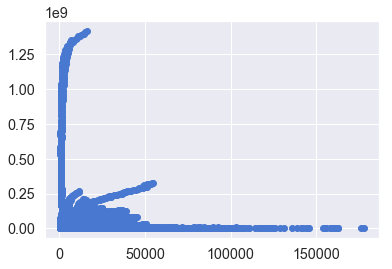

In [54]:
plt.scatter(x='income', y='population',
           label='hey', data=world_data)

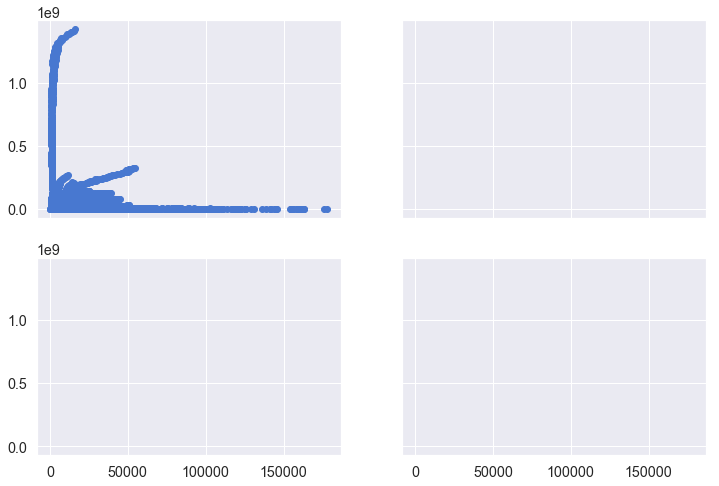

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8),
                                             sharex=True, sharey=True)
ax1.scatter(x='income', y='population',
           label='hey', data=world_data)

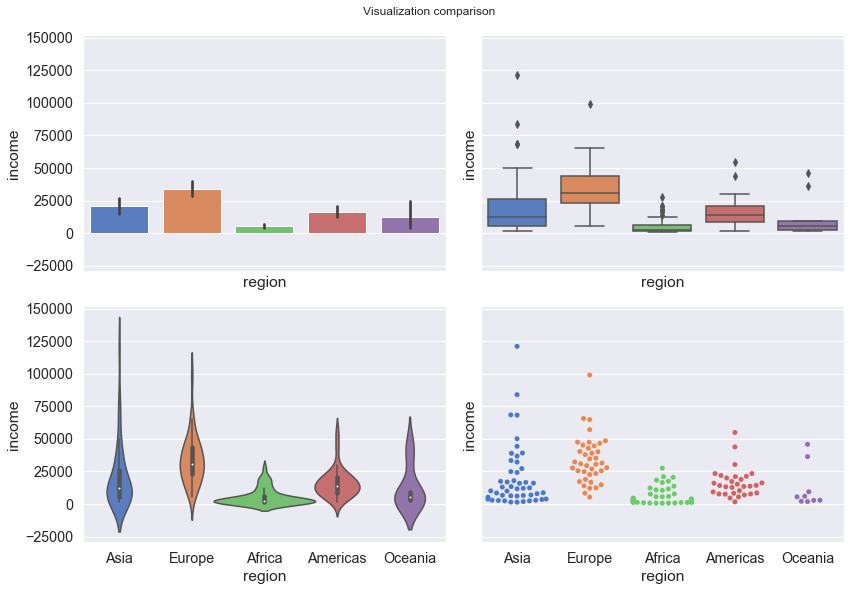

In [49]:
import matplotlib.pyplot as plt


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8),
                                             sharex=True, sharey=True)
fig.suptitle('Visualization comparison', y=1.02) # `y` is used to place the title a little bit higher up

sns.barplot(x='region', y='income', data=world_data_2018, ax=ax1)
sns.boxplot(x='region', y='income', data=world_data_2018, ax=ax2)
sns.violinplot(x='region', y='income', data=world_data_2018, ax=ax3, width=1.4)
sns.swarmplot(x='region', y='income', data=world_data_2018, ax=ax4)

# Remove the axis labels for region and income where it's not needed
# ax1.set_xlabel('')
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax3.set_xlabel('')
# ax4.set_xlabel('')
# ax4.set_ylabel('')

fig.tight_layout()

>#### Challenge 3
>
>1. How many data points and/or distribution statistics are displayed in each of these plots 
>2. Out of the these plots, which one do you think is the most informative and why? Which is the most true to the underlying data?

### Pros and cons of different graph types

We will deepen the discussion around some of these ideas, in the context of the following plot:

![*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*](./img/dynamite-bars.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

It is generally advisable to avoid "decorative" plot elements that do not convey extra information about the data, *especially* when such elements hide the real data. An early champion of this idea was Edward Tufte, who details how to reduce so called non-data ink and many other things in his book [The visual display of quantitative information](https://www.edwardtufte.com/tufte/books_vdqi). In the bar chart above, the only relevant information is given by the where the rectangles of the bars ends on the y-axis, the rest of it is unnecessary. Instead of using the rectangle's height, a simpler marker (circle, square, etc) could have been used to indicate the height on the y-axis. Note that the body of the rectangle is not representative for where the data lies, there are probably no data points close to 0, and several above the rectangle.

Barplots are especially misleading when used as data summaries, as in the
example above. In a summary plot, only two distribution parameters (a measure of
central tendency, e.g. the mean, and error, e.g. the standard deviation or a
confidence interval) are displayed, instead of showing all the individual data
points. This can be highly misleading, since different underlying distributions
can give rise to the same summary plot. We also have no idea of how many observations there are in each group. These
shortcomings become evident when comparing the barplot to the underlying
distributions that were used to create them:

![*Reproduced with permission from [Dr. Koyama's poster*](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)](./img/dynamite-vs-dists.png)

*Reproduced with permission from [Dr. Koyama's poster](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/TatsukiKoyama/Poster3.pdf)*

Immediately, you can see that conclusions drawn from the barplot, such that A
and B have the same outcome, are factually incorrect. The distribution in D is
bimodal, so representing that with a mean would be like observing black and
white birds and conclude that the average bird color is grey, it's nonsensical.
If we would have planned our follow up experiments based on the barplot alone,
we would have been setting ourselves up for failure! Always be sceptical when
you see a barplot in a published paper, and think of how the underlying
distribution might look (note that barplots are more acceptable when used to
represents counts, proportion or percentages, where there is only one data point
per group in the data set).

Boxplots and violin plots are more meaningful data summaries as they represent more than just two distribution parameters (such as mean +/- sd). However, these can still be misleading and it is often the most appropriate to show each individual observation with a dot/hive/swarm plot, possibly combined with a superimposed summary plot or a marker for the mean or median *if* this additional information is useful. One exception, when it is not advisable to show all data points, is when the data set is gigantic and plotting each individual observation would oversaturate the chart. In that case, plot summary statistics or a 2D histogram (more on this later).

Here is an example of how a violinplot can be combined together with the individual observations in `seaborn`.

Text(0.5,0,'')

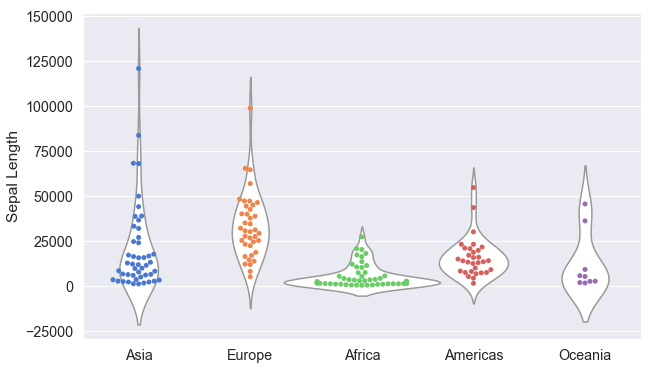

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(x='region', y='income', data=world_data_2018,
               color='white', inner=None, ax=ax, width=1.4)
sns.swarmplot(x='region', y='income', data=world_data_2018, ax=ax)

ax.set_ylabel('Sepal Length')
ax.set_xlabel('')

Plotting elements have a default order in which they appear. This can be changed by explicitly via the `zorder` parameter.

Text(0.5,0,'')

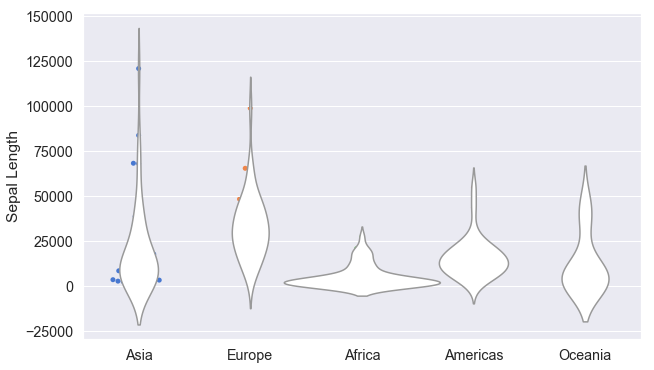

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(x='region', y='income', data=world_data_2018,
               color='white', inner=None, ax=ax, width=1.4)
sns.swarmplot(x='region', y='income', data=world_data_2018,
              ax=ax, zorder=0)

ax.set_ylabel('Sepal Length')
ax.set_xlabel('')

This is not very helpful in this particular case, but it is good to be aware of the `zorder` parameter if the need arises to combine plots.

>#### Challenge 4
>
>1. Combine a `stripplot()` with a `boxplot()`. Set the `jitter` parameter to distribute the dots so that they are not all on one line.

## Making plots accessible through suitable color choices

Colour blindness is common in the population, and red-green colour blindness in particular affects 8% of men and 0.5% of women. Guidelines for making your visualizations more accessible to people affected by colour blindness, will in many cases also improve the interpretability of your graphs for people who have standard color vision. Here are a couple of examples:

Don't use jet rainbow-coloured heatmaps. Jet colourmaps are often the default heatmap used in many visualization packages (you've probably seen them before). 

![](./img/heatmap.png)

Colour blind viewers are going to have a difficult time distinguishing the meaning of this heat map if some of the colours blend together.

![](./img/colourblind.png)

The jet colormap should be avoided for other reasons, including that the sharp transitions between colors introduces visual threshold levels that do not represent the underlying continuous data. Another issue is luminance, or brightness. For example, your eye is drawn to the yellow and cyan regions, because the luminance is higher. This can have the unfortunate effect of highlighting features in your data that don't actually exist, misleading your viewers! It also means that your graph is not going to translate well to greyscale in publication format.

More details about jet can be found in [this blog post](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) and [this series of posts](https://mycarta.wordpress.com/2012/05/12/the-rainbow-is-dead-long-live-the-rainbow-part-1/). In general, when presenting continuous data, a perceptually uniform colormap is often the most suitable choice. This type of colormap ensures that equal steps in data are perceived as equal steps in color space. The human brain perceives changes in lightness as changes in the data much better than, for example, changes in hue. Therefore, colormaps which have monotonically increasing lightness through the colormap will be better interpreted by the viewer. More details and examples of such colormaps are available in the [`matplotlib` documentation](http://matplotlib.org/users/colormaps.html), and many of the core design principles are outlined in [this entertaining talk](https://www.youtube.com/watch?v=xAoljeRJ3lU).

The default colormap in `matplotlib` is `viridis` which to have monotonically increasing lightness throughout. There is also `cividis`, which is designed to look the same for common colorblindess as for people without colorblindness. Heatmaps is a good example on where color matters

In a correlation matrix, the diagonal is a column's correlaiton with itself, so it is always perfect (1). The same values are mirrored above and below the diagonal.

Another approach to improve visualization clarity is to use different symbols for the groups and to change the color palette to one specifically designed to work well for common colorblindness.

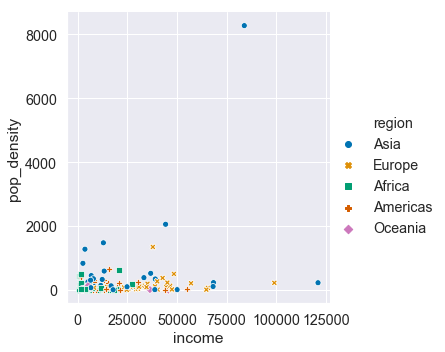

In [7]:
# To see all available palettes, set it to an empty string and view the error message
sns.relplot(x='income', y='pop_density', hue='region', style='region', 
            data=world_data_2018, palette='colorblind')

>#### Challenge 5 (optional)
>
>1. Take one of the figures created previously and upload it to [this website](http://www.color-blindness.com/coblis-color-blindness-simulator/) to see how it  looks in the color blindness simulator.

## Avoiding saturated plots

Summary plots (especially bar plots) were previously mentioned to potentially be misleading, and it is often most appropriate to show every individual observation with a dot plot or the like, perhaps combined with summary markers where appropriate. But, what if the data set is too big to visualize every single observations? In large data sets, it is often the case that plotting each individual observation would oversaturate the chart.  

When plotting a data frame, `matplotlib` plotting functions can be made aware of the structure of the data by specifying the `data` parameter and the `x` and `y` parameters can then be specified just by passing the name of a column in the data frame as a string.

In [8]:
diamonds = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2/diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


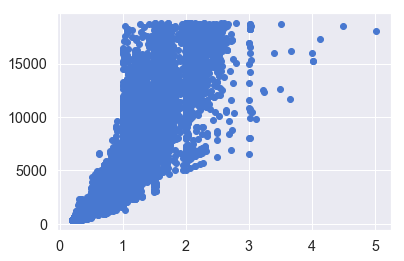

In [9]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds)

Because this is a dataset with 33,288 observations, visualizing it in two dimensions creates a graph that is incredibly oversaturated. Oversaturated graphs make it *far more* difficult to glean information from the visualization. Maybe adjusting the size of each observation could help?

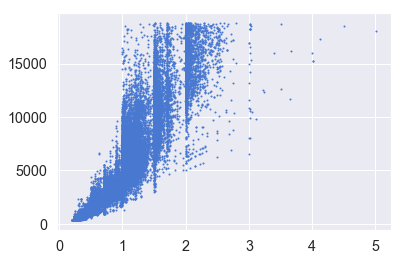

In [10]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1)

That's a bit better. Reducing the transparency might help further.

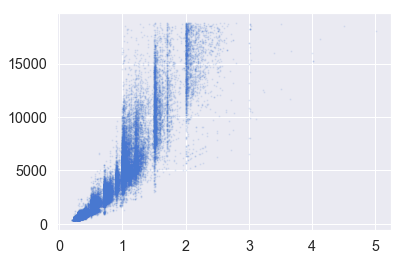

In [11]:
fig, ax = plt.subplots()
ax.scatter('carat', 'price', data=diamonds, s=1, alpha=0.1)

This is clearer than initially, but does still not reveal the full structure of the underlying data. Before proceeding, add axis labels and remove the axis lines (spines) on the top and the right.

The result is still not satisfactory, which illustrates that a scatter plot is simply not a good choice with huge data sets. A more suitable plot type for this data, is a so called `hexbin` plot, which essentially is a two dimensional histogram, where the color of each hexagonal bin represents the amount of observations in that bin (analogous to the height in a one dimensional histogram). 

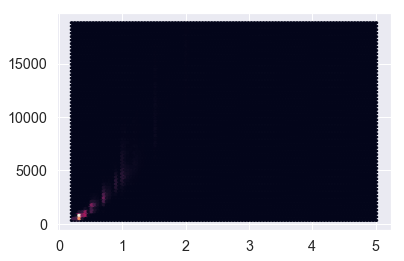

In [12]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds)

This looks ugly because the bins with zero observations are still colored. This can be avoided by setting the minimum count of observations to color a bin.

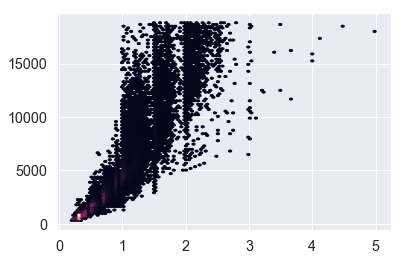

In [13]:
fig, ax = plt.subplots()
ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
# ax.hexbin('income', 'life_expectancy', data=survey, mincnt=1)

The distribution of the data is not more akin to that of the scatter plot. To know what the different colors represent, a colorbar needs to be added to this plot. The space for the colorbar will be taken from a plot in the current figure.

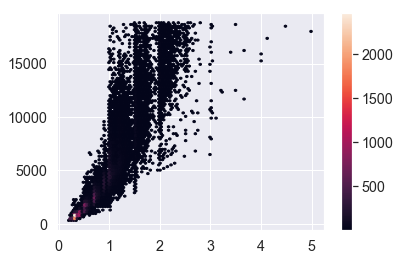

In [14]:
fig, ax = plt.subplots()
# Assign to a variable to reuse with the colorbar
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1)
# Create the colorbar from the hexbin plot axis
cax = fig.colorbar(hex_plot)

Notice that the overall figure is the same size, and the axes that contains the hexbin plot shrank to make room for the colorbar. To remind ourselves what is plotted, axis labels can be added like previously.

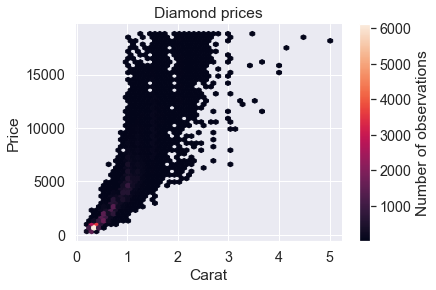

In [15]:
fig, ax = plt.subplots()
hex_plot = ax.hexbin('carat', 'price', data=diamonds, mincnt=1, gridsize=50)
sns.despine()
cax = fig.colorbar(hex_plot)

ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
cax.set_label('Number of observations')

It is now clear that the yellow area represents over 2000 observations!

Text(0,0.5,'Price')

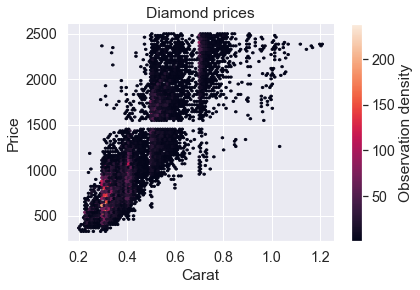

In [16]:
diamonds_subset = diamonds.loc[(diamonds['carat'] < 1.3) & (diamonds['price'] < 2500)]

fig, ax = plt.subplots()
hexbin = ax.hexbin('carat', 'price', data=diamonds_subset, mincnt=1)
sns.despine()
cax = fig.colorbar(hexbin)

cax.set_label('Observation density')
ax.set_title('Diamond prices')
ax.set_xlabel('Carat')
ax.set_ylabel('Price')

Although this hexbin plot is a great way of visualizing the distributions, it could be valuable to compare it to the histograms for each the plotted variable.

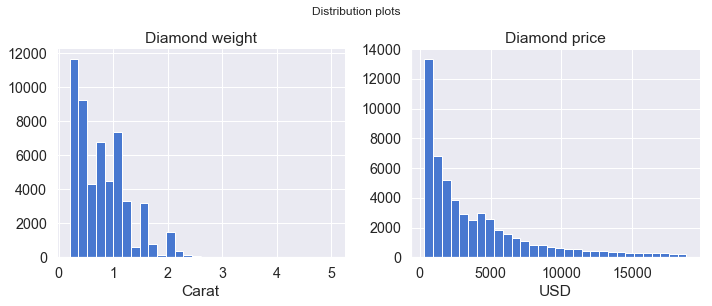

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Distribution plots', y=1.05)
sns.despine()

ax1.hist('carat', bins=30, data=diamonds) 
ax1.set_title('Diamond weight')
ax1.set_xlabel('Carat')

ax2.hist('price', bins=30, data=diamonds) 
ax2.set_title('Diamond price')
ax2.set_xlabel('USD')

fig.tight_layout()

Since visualizing two individual 1D distribution together with their joint 2D distribution is a common operation, `seaborn` has a built-in function to create a hexbin plot with histograms on the marginal axes.

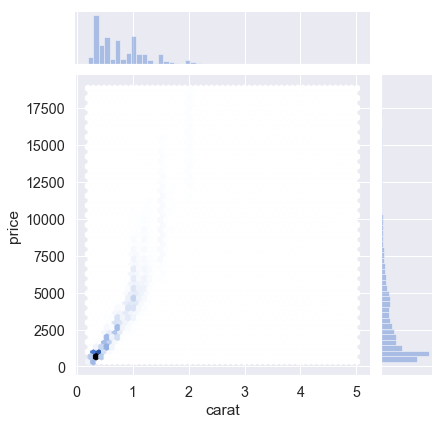

In [18]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='hex')

This can be customized to appear more like the previous hexbin plots. Since `joinplot()` deals with both the hexbin and the histogram, the parameter names must be separated so that it is clear which plot they are referring to. This is done by passing them as dictionaries to the `joint_kws` and `marginal_kws` parameters ("kws" stands for "keywords").

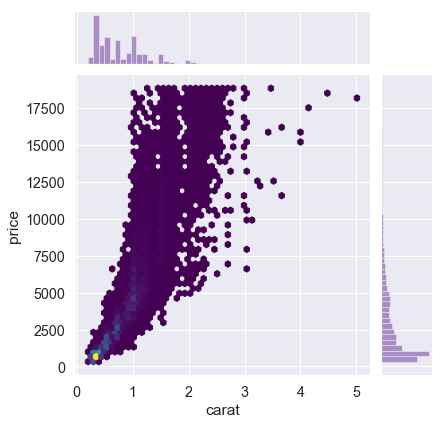

In [19]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='hex', 
              joint_kws={'cmap':'viridis', 'mincnt':1},
              marginal_kws={'color': 'indigo'})

/home/joel/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'mincnt'
  s)


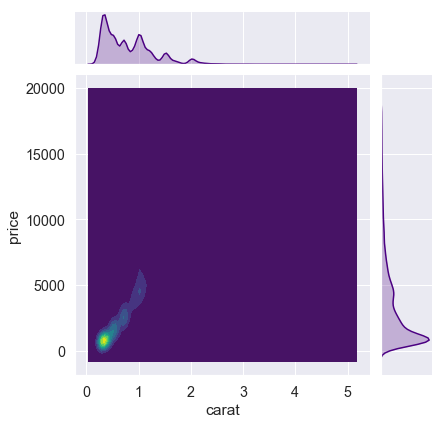

In [20]:
sns.jointplot(x='carat', y='price', data=diamonds, kind='kde', 
              joint_kws={'cmap':'viridis', 'mincnt':1},
              marginal_kws={'color': 'indigo'})

## Reshaping data between long and wide formats

Data is often presented in a so-called wide format, e.g. with one column per measurement:

|person|weight|height|age|
|------|------|------|---|
|A|70|170|32|
|B|85|179|28|

This can be a great way to display data so that it is easily interpretable by humans and is often used for summary statistics (commonly referred to as pivot tables). However, many data analysis functions in `pandas`, `seaborn` and other packages are optimized to work with the tidy data format. Tidy data is a long format where each row is a single observation and each column contains a single variable:

|person|measure|value|
|------|-----------|-----|
|     A|     weight|   70|
|     A|     height|  170|
|     A|        age|   32|
|     B|     weight|   85|
|     B|     height|  179|
|     B|        age|   28|

`pandas` enables a wide range of manipulations of the structure of data, including alternating between the long and wide format. The survey data presented here is in a tidy format. To facilitate visual comparisons of the relationships between measurements across columns, it would be beneficial to display this data in the wide format. For example, what is the relationship between mean weights of different species caught at the same plot type?

### Subset data

To facilitate the visualization of the the transformations between wide and tidy data,  it is beneficial to create a subset of the data.

In [21]:
world_data_2014 = world_data.loc[world_data['year'].isin(['2014'])]
world_data_2014.head()

,country,year,population,region,sub_region,income_group,life_expectancy,income,children_per_woman,child_mortality,pop_density,co2_per_capita,years_in_school_men,years_in_school_women
214,Afghanistan,2014,32800000,Asia,Southern Asia,Low,57.8,1780,4.98,76.1,50.2,0.299,4.04,0.95
433,Albania,2014,2920000,Europe,Southern Europe,Upper middle,77.4,10700,1.71,14.4,107.0,1.960,11.80,12.10
652,Algeria,2014,39100000,Africa,Northern Africa,Upper middle,77.1,13500,2.89,25.6,16.4,3.720,8.38,7.58
871,Angola,2014,26900000,Africa,Sub-Saharan Africa,Lower middle,63.3,6260,5.84,91.2,21.6,1.290,7.11,5.18
1090,Antigua and Barbuda,2014,98900,Americas,Latin America and the Caribbean,High,77.1,19500,2.08,9.0,225.0,5.380,13.10,14.30


In [22]:
world_data_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 214 to 38977
Data columns (total 14 columns):
country                  178 non-null object
year                     178 non-null int64
population               178 non-null int64
region                   178 non-null object
sub_region               178 non-null object
income_group             178 non-null object
life_expectancy          178 non-null float64
income                   178 non-null int64
children_per_woman       178 non-null float64
child_mortality          178 non-null float64
pop_density              178 non-null float64
co2_per_capita           178 non-null float64
years_in_school_men      178 non-null float64
years_in_school_women    178 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 20.9+ KB


Let's look at the average CO2 emissions across reions and income_group.

In [23]:
world_data_2014_co2avg = (
    world_data_2014
        .groupby(['region','income_group'])['co2_per_capita']
        .mean()
        .reset_index()
)
world_data_2014_co2avg

,region,income_group,co2_per_capita
0,Africa,High,5.310000
1,Africa,Low,0.206270
2,Africa,Lower middle,0.930375
3,Africa,Upper middle,4.696250
4,Americas,High,9.565000
5,Americas,Low,0.271000
6,Americas,Lower middle,1.204750
7,Americas,Upper middle,2.519375
8,Asia,High,17.914545
9,Asia,Low,0.879667


### Long to wide with `pivot()` and `pivot_table()`

The data we created is a long or tidy format. A long to wide transformation would be suitable to effectively visualize the relationship between the average co2 emission of the countries based on their region and income. 

To remove the repeating information for `region` and `income_group`, this table can be pivoted into a wide formatted using the `pivot()` method. The arguments passed to `pivot()` includes the rows (the index), the columns, and which values should populate the table. 

In [24]:
world_data_2014_pvt = world_data_2014_co2avg.pivot(
    index='region', columns='income_group', values='co2_per_capita')
world_data_2014_pvt

income_group,High,Low,Lower middle,Upper middle
region,,,,
Africa,5.310000,0.206270,0.930375,4.696250
Americas,9.565000,0.271000,1.204750,2.519375
Asia,17.914545,0.879667,1.564824,6.210769
Europe,6.921429,NaN,3.135000,5.280000
Oceania,11.495000,NaN,0.581000,1.163333


Compare how this table is displayed with the table in the previous cell. It is certainly easier to spot differences between the species and plot types in this wide format.

Since presenting summary statistics in a wide format is such a common operation, `pandas` has a dedicated method, `pivot_table()`, that performs both the data aggregation and pivoting.

In [25]:
world_data_2014.pivot_table(
    index='region', columns='income_group',
    values='co2_per_capita', margins=True
)

income_group,High,Low,Lower middle,Upper middle,All
region,,,,,
Africa,5.310000,0.206270,0.930375,4.696250,1.217987
Americas,9.565000,0.271000,1.204750,2.519375,4.550000
Asia,17.914545,0.879667,1.564824,6.210769,6.588936
Europe,6.921429,NaN,3.135000,5.280000,6.348462
Oceania,11.495000,NaN,0.581000,1.163333,3.200444
All,9.900192,0.327009,1.276767,4.278163,4.440783


With `pivot_table()` it is also possible to change the aggregation function.

In [26]:
world_data_2014.pivot_table(
    index='region', columns='income_group', 
    values='co2_per_capita', margins=True, aggfunc='median'
)

income_group,High,Low,Lower middle,Upper middle,All
region,,,,,
Africa,5.310,0.1470,0.6510,3.540,0.339
Americas,5.065,0.2710,1.0400,2.435,2.590
Asia,15.400,0.7425,1.0600,4.620,3.270
Europe,6.010,NaN,3.1350,4.240,5.870
Oceania,11.495,NaN,0.5795,1.140,1.030
All,6.630,0.1940,0.8920,3.500,2.435


Although `pivot_table()` is the most convenient way to aggregate *and* pivot data, `pivot()` is still useful to reshape a data frame from wide to long *without* performing aggregation.

The columns and rows can be swapped in the call to `pivot_table()`. This is useful both to present the table differently and to perform computations on a different axis (dimension) of the data frame (this result can also be obtained by calling the `transpose()` method).

In [27]:
world_data_2014.pivot_table(index='income_group', columns='region', values='co2_per_capita')

region,Africa,Americas,Asia,Europe,Oceania
income_group,,,,,
High,5.310000,9.565000,17.914545,6.921429,11.495000
Low,0.206270,0.271000,0.879667,NaN,NaN
Lower middle,0.930375,1.204750,1.564824,3.135000,0.581000
Upper middle,4.696250,2.519375,6.210769,5.280000,1.163333


### Wide to long with `melt()`

It is also a common operation to reshape data from the wide to the long format, e.g. when getting the data into the most suitable format for analysis. For this transformation, the `melt()` method can be used to sweep up a set of columns into one key-value pair.

To prepare the data frame, the `plot_type` index name can be moved to a column name with the `reset_index()` method.

In [28]:
world_data_2014_pvt

income_group,High,Low,Lower middle,Upper middle
region,,,,
Africa,5.310000,0.206270,0.930375,4.696250
Americas,9.565000,0.271000,1.204750,2.519375
Asia,17.914545,0.879667,1.564824,6.210769
Europe,6.921429,NaN,3.135000,5.280000
Oceania,11.495000,NaN,0.581000,1.163333


In [29]:
world_data_2014_res = world_data_2014_pvt.reset_index()
world_data_2014_res

income_group,region,High,Low,Lower middle,Upper middle
0,Africa,5.310000,0.206270,0.930375,4.696250
1,Americas,9.565000,0.271000,1.204750,2.519375
2,Asia,17.914545,0.879667,1.564824,6.210769
3,Europe,6.921429,NaN,3.135000,5.280000
4,Oceania,11.495000,NaN,0.581000,1.163333


At a minimum, `melt()` only requires the name of the column that should be kept intact. All remaining columns will have their values in the `value` column and their name in the `variable` column (here, our columns already has a name "income_group", so this will be used automatically instead of "variable").

In [30]:
world_data_2014_res.melt(id_vars='region')

,region,income_group,value
0,Africa,High,5.310000
1,Americas,High,9.565000
2,Asia,High,17.914545
3,Europe,High,6.921429
4,Oceania,High,11.495000
5,Africa,Low,0.206270
6,Americas,Low,0.271000
7,Asia,Low,0.879667
8,Europe,Low,NaN
9,Oceania,Low,NaN


To be more explicit, all the arguments to `melt()` can be specified. This way it is also possible to exclude some columns, e.g. the income group 'Lower middle'.

In [31]:
world_data_2014_res.melt(id_vars='region', value_vars=['High','Low','Lower middle','Upper middle'], 
                     var_name='income_group', value_name='co2_per_capita')

,region,income_group,co2_per_capita
0,Africa,High,5.310000
1,Americas,High,9.565000
2,Asia,High,17.914545
3,Europe,High,6.921429
4,Oceania,High,11.495000
5,Africa,Low,0.206270
6,Americas,Low,0.271000
7,Asia,Low,0.879667
8,Europe,Low,NaN
9,Oceania,Low,NaN


>#### Challenge 1
>
> 1. Subset the data to contain only the year 1950 and the region Southern Europe.
> 2. Reset the index of this data frame and assign it to a new variable name
> 3. Create a tidy data frame with country as the id column, and `pop_density` and `co2_per_capita` as values in the variable column.

In [32]:
# Challenge solution
# 1.
world_data_1950_se = world_data.loc[world_data['year'].isin(['1950']) & world_data['sub_region'].isin(['Southern Europe'])]

# 2.
world_data_1950_se_res = world_data_1950_se.reset_index()[['country','pop_density','co2_per_capita']]

# 3.
world_data_1950_tidy = world_data_1950_se_res.melt(id_vars='country')
# if we wanted to drop the NaN values in the previous format we had to index a 2D dataframe
# but in a tidy data format it's easier to drop the NaN values:
world_data_1950_tidy.dropna()

,country,variable,value
0,Albania,pop_density,46.100
1,Bosnia and Herzegovina,pop_density,52.200
2,Croatia,pop_density,68.800
3,Greece,pop_density,59.500
4,Italy,pop_density,158.000
5,"Macedonia, FYR",pop_density,49.700
6,Malta,pop_density,975.000
7,Montenegro,pop_density,29.300
8,Portugal,pop_density,91.900
9,Serbia,pop_density,77.000


# Cleaning data (time permitting)

`pandas` has many helpful methods for cleaning data, [an overview can be found in the documentation](https://pandas.pydata.org/pandas-docs/stable/missing_data.html). We will explore the most commonly used methods here. First, let's load a sample data frame with some dirty raw data that needs cleaning.

In [33]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/UofTCoders/2018-09-10-utoronto/gh-pages/data/raw_dirty_data.csv')
clean_df = raw_data.copy() # To ensure the original df is not modified
clean_df

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070
1,samoa,2012,189000.0,Oceania.Polynesia,Upper middle,no value,NaN
2,Sammoa,2013,191000.0,Oceania.Polynesia,Upper middle,71.6,NaN
3,Samoa,2014,NaN,Oceania.Polynesia,Upper middle,missing,1.030
4,Samia,2015,194000.0,Oceania.Polynesia,Upper middle,71.7,NaN
5,Samoa,2016,195000.0,Oceania.Polynesia,Upper middle,72.0,NaN
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982
7,Tonga,2012,NaN,Oceania.Polynesia,Upper middle,70.0,1.010
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140


A few rows in this data frame contain missing values. As mentioned earlier, there are several ways to handle missing values. A robust option is to remove any rows with missing values, which can be done wth the `dropna()` method of the data frame.

In [34]:
clean_df.dropna()

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140


By default all columns are considered. However, if the purpose is to study the population changes over time, it is not desirable to drop rows with valid population values just because they are missing a co2 measurement. `dropna()` can therefore be adjusted to only consider specific columns.

In [35]:
clean_df.dropna(subset=['population'])

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070
1,samoa,2012,189000.0,Oceania.Polynesia,Upper middle,no value,NaN
2,Sammoa,2013,191000.0,Oceania.Polynesia,Upper middle,71.6,NaN
4,Samia,2015,194000.0,Oceania.Polynesia,Upper middle,71.7,NaN
5,Samoa,2016,195000.0,Oceania.Polynesia,Upper middle,72.0,NaN
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140
10,Tonga,2015,106000.0,Oceania.Polynesia,Upper middle,not given,NaN
11,Tonga,2016,107000.0,Oceania.Polynesia,Upper middle,70.4,NaN


A common alternative to removing rows containing `NA` values is to fill out the values with e.g. the mean of all observations or the previous non-NA value. This can be done with the `fillna()` method.

In [36]:
# Fill missing values with mean value for that column
raw_data.fillna(raw_data.mean())

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070
1,samoa,2012,189000.0,Oceania.Polynesia,Upper middle,no value,1.052
2,Sammoa,2013,191000.0,Oceania.Polynesia,Upper middle,71.6,1.052
3,Samoa,2014,148600.0,Oceania.Polynesia,Upper middle,missing,1.030
4,Samia,2015,194000.0,Oceania.Polynesia,Upper middle,71.7,1.052
5,Samoa,2016,195000.0,Oceania.Polynesia,Upper middle,72.0,1.052
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982
7,Tonga,2012,148600.0,Oceania.Polynesia,Upper middle,70.0,1.010
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140


In this case, it would have been better to calculate different values for the different countries.

Another way of filling values is to copy the previous or next value. This is especially relevant in time series where the values are ordered chronologically.

In [37]:
# Fill with previews non-null value
raw_data.fillna(method='ffill')

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070
1,samoa,2012,189000.0,Oceania.Polynesia,Upper middle,no value,1.070
2,Sammoa,2013,191000.0,Oceania.Polynesia,Upper middle,71.6,1.070
3,Samoa,2014,191000.0,Oceania.Polynesia,Upper middle,missing,1.030
4,Samia,2015,194000.0,Oceania.Polynesia,Upper middle,71.7,1.030
5,Samoa,2016,195000.0,Oceania.Polynesia,Upper middle,72.0,1.030
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982
7,Tonga,2012,105000.0,Oceania.Polynesia,Upper middle,70.0,1.010
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140


For NA values that are surrounded by two measurements, the most appropriate method could be to interpolate the missing values. The default interpolation method is to linearly estimate the values, but there are many more options.

In [38]:
clean_df.interpolate(limit_direction='both')

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,Upper middle,71.5,1.070000
1,samoa,2012,189000.0,Oceania.Polynesia,Upper middle,no value,1.056667
2,Sammoa,2013,191000.0,Oceania.Polynesia,Upper middle,71.6,1.043333
3,Samoa,2014,192500.0,Oceania.Polynesia,Upper middle,missing,1.030000
4,Samia,2015,194000.0,Oceania.Polynesia,Upper middle,71.7,1.014000
5,Samoa,2016,195000.0,Oceania.Polynesia,Upper middle,72.0,0.998000
6,Tonga,2011,105000.0,Oceania.Polynesia,Upper middle,70.0,0.982000
7,Tonga,2012,105000.0,Oceania.Polynesia,Upper middle,70.0,1.010000
8,Tonga,2013,105000.0,Oceania.Polynesia,Upper middle,70.1,1.080000
9,Tonnga,2014,106000.0,Oceania.Polynesia,Upper middle,70.2,1.140000


Whether to use `dropna()`, `fillna()`, or `interpolate()` depends on the data set and the purpose of the analysis.

Data frames have plenty of built-in `str` [(string) methods](https://pandas.pydata.org/pandas-docs/stable/api.html#string-handling) and many of these are helpful when handling typos and text formatting. Say for examples that it is desired to have the values of the `income_group` column as lower case characters. 

In [39]:
clean_df['income_group'].str.lower()

0     upper middle
1     upper middle
2     upper middle
3     upper middle
4     upper middle
5     upper middle
6     upper middle
7     upper middle
8     upper middle
9     upper middle
10    upper middle
11    upper middle
Name: income_group, dtype: object

The space can easily be replaced with an underscore.

In [40]:
clean_df['income_group'].str.lower().str.replace(' ', '-')

0     upper-middle
1     upper-middle
2     upper-middle
3     upper-middle
4     upper-middle
5     upper-middle
6     upper-middle
7     upper-middle
8     upper-middle
9     upper-middle
10    upper-middle
11    upper-middle
Name: income_group, dtype: object

This can then be assigned back to the original data frame.

In [41]:
clean_df['income_group'] = clean_df['income_group'].str.lower().str.replace(' ', '-')
clean_df

,country,year,population,region,income_group,life_expectancy,co2_per_capita
0,Samoa,2011,188000.0,Oceania.Polynesia,upper-middle,71.5,1.070
1,samoa,2012,189000.0,Oceania.Polynesia,upper-middle,no value,NaN
2,Sammoa,2013,191000.0,Oceania.Polynesia,upper-middle,71.6,NaN
3,Samoa,2014,NaN,Oceania.Polynesia,upper-middle,missing,1.030
4,Samia,2015,194000.0,Oceania.Polynesia,upper-middle,71.7,NaN
5,Samoa,2016,195000.0,Oceania.Polynesia,upper-middle,72.0,NaN
6,Tonga,2011,105000.0,Oceania.Polynesia,upper-middle,70.0,0.982
7,Tonga,2012,NaN,Oceania.Polynesia,upper-middle,70.0,1.010
8,Tonga,2013,105000.0,Oceania.Polynesia,upper-middle,70.1,1.080
9,Tonnga,2014,106000.0,Oceania.Polynesia,upper-middle,70.2,1.140


Note that the NA values are still around because the original data frame was never overwritten with modified one without NA values.

To find spelling mistakes the `unique()` method is useful.

In [42]:
clean_df['country'].unique()

array(['Samoa', 'samoa', 'Sammoa', 'Samia', 'Tonga', 'Tonnga'],
      dtype=object)

The `replace()` method can be used here again, this time replacing several spelling mistakes simultaneously.

In [43]:
(clean_df['country']
     .str.replace('samoa|Samia', 'Samoa')
     .str.replace('Tonnga', 'Tonga')
     .unique()
)

array(['Samoa', 'Sammoa', 'Tonga'], dtype=object)

The `|` bar means `or`, similar to how we saw it used previously with `loc[]`. Using a `|` in a string like this work because the `str.replace()` method supports "regular expressions". This is a powerful way of using strings as search patterns, such as with `|`, rather than interpreting the literally.

A more powerful "regular expression" to replace everything starting with `S` or `s` with `Samoa` and every word starting with `T` with `Tongo` would look like this.

In [44]:
(clean_df['country']
     .str.replace('[S,s].*', 'Samoa') # .* means "any sequence of characters
     .str.replace('T.*', 'Tonga')
     .unique()
)

array(['Samoa', 'Tonga'], dtype=object)

Entire books have been written on regular expressions and covering them fully here is outside the scope of this tutorial, but it is very useful to know about `|` (and to a lesser extent `[]` and `.*`) when replacing misspelled words.

Another common data cleaning operation is to split one column into two in order to have one measurement per column. This can be done via `str.split()`.

In [45]:
clean_df['region'].str.split('.')

0     [Oceania, Polynesia]
1     [Oceania, Polynesia]
2     [Oceania, Polynesia]
3     [Oceania, Polynesia]
4     [Oceania, Polynesia]
5     [Oceania, Polynesia]
6     [Oceania, Polynesia]
7     [Oceania, Polynesia]
8     [Oceania, Polynesia]
9     [Oceania, Polynesia]
10    [Oceania, Polynesia]
11    [Oceania, Polynesia]
Name: region, dtype: object

To assign the results to two different columns The returned object is a series where each row is a list of two values. This cannot be assigned to to different columns in the data frame, since there is only one column in the output. To get around this, we can append `str` to the output, which allows assigning the first item of each list to the first specified column and the second item to the second specified column.

In [46]:
clean_df['region'], clean_df['sub_region'] = clean_df['region'].str.split('.').str
clean_df
# To get only one of the list items, use indexing
# clean_df['region'], clean_df['sub_region'] = clean_df['region'].str.split('.').str[0]

,country,year,population,region,income_group,life_expectancy,co2_per_capita,sub_region
0,Samoa,2011,188000.0,Oceania,upper-middle,71.5,1.070,Polynesia
1,samoa,2012,189000.0,Oceania,upper-middle,no value,NaN,Polynesia
2,Sammoa,2013,191000.0,Oceania,upper-middle,71.6,NaN,Polynesia
3,Samoa,2014,NaN,Oceania,upper-middle,missing,1.030,Polynesia
4,Samia,2015,194000.0,Oceania,upper-middle,71.7,NaN,Polynesia
5,Samoa,2016,195000.0,Oceania,upper-middle,72.0,NaN,Polynesia
6,Tonga,2011,105000.0,Oceania,upper-middle,70.0,0.982,Polynesia
7,Tonga,2012,NaN,Oceania,upper-middle,70.0,1.010,Polynesia
8,Tonga,2013,105000.0,Oceania,upper-middle,70.1,1.080,Polynesia
9,Tonnga,2014,106000.0,Oceania,upper-middle,70.2,1.140,Polynesia


To get rid of certain rows or columns, the `drop()` method can be used.

In [47]:
clean_df.drop(index=[1, 4, 5], columns=['region', 'year', 'country'])

,population,income_group,life_expectancy,co2_per_capita,sub_region
0,188000.0,upper-middle,71.5,1.070,Polynesia
2,191000.0,upper-middle,71.6,NaN,Polynesia
3,NaN,upper-middle,missing,1.030,Polynesia
6,105000.0,upper-middle,70.0,0.982,Polynesia
7,NaN,upper-middle,70.0,1.010,Polynesia
8,105000.0,upper-middle,70.1,1.080,Polynesia
9,106000.0,upper-middle,70.2,1.140,Polynesia
10,106000.0,upper-middle,not given,NaN,Polynesia
11,107000.0,upper-middle,70.4,NaN,Polynesia


> # Challenge
>
> 1. Create a new data frame called `world_data_co2` from the `world_data` data that contains only the `country`, `year`, `population` and `co2_pet_capita` columns and no NA values.
> 2. Create a new column in `clean_df_co2` called `total_co2` containing the total co2 emissions of the country using the per capita value in `co2_per_capita` and the `population` column.
> 3. Retrieve all observations that have a `total_co2` value greater than 10,000,000.

### More general resources on plotting

- [Ten Simple Rules for Better Figures](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003833)
- [Finding the Right Color Palettes for Data Visualizations](https://blog.graphiq.com/finding-the-right-color-palettes-for-data-visualizations-fcd4e707a283)
- [Examples of bad graphs](https://www.biostat.wisc.edu/~kbroman/topten_worstgraphs/)
- [More examples of bad graphs and how to improve them](https://www.stat.auckland.ac.nz/~ihaka/120/Lectures/lecture03.pdf)
- [Wikipedia has a great article on misleading graphs](https://en.wikipedia.org/wiki/Misleading_graph)
- [Usability article about how to design for people with color blindness](http://blog.usabilla.com/how-to-design-for-color-blindness/)